In [55]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2)
library(Matching)
library(dplyr)
library(marginaleffects)
library(MatchIt)
library(knitr)

# Load master dataset
ma_final <- read_csv("../../hwk2/data/output/final_ma_data.csv", show_col_types = FALSE)

<style>
pre, code {
  white-space: pre-wrap !important;
  word-break: break-all !important;
}
</style>

# Question 1

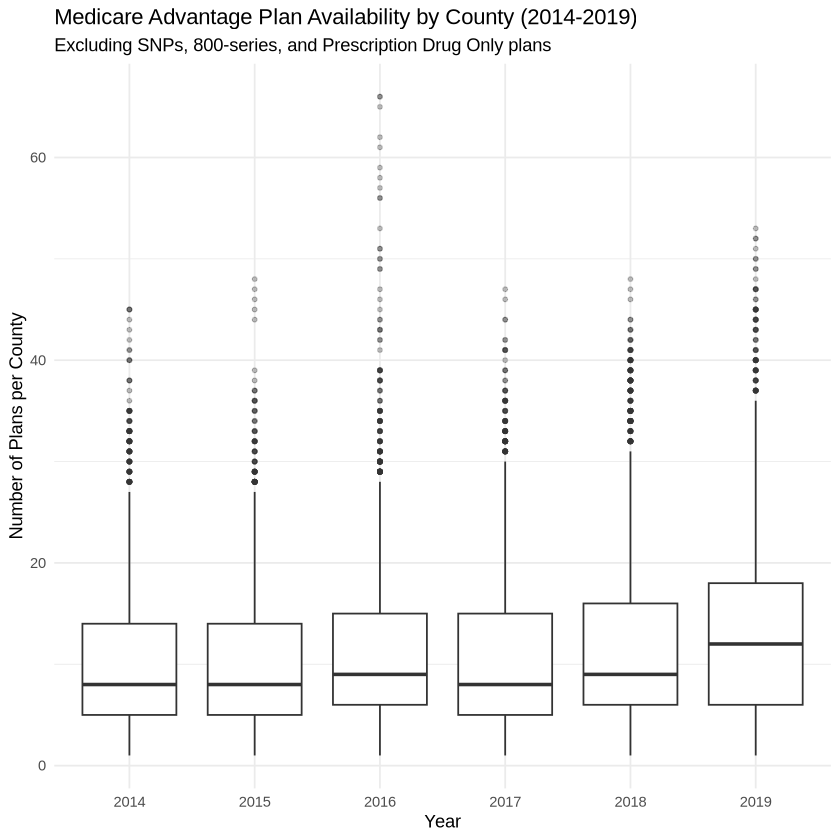

In [33]:
# Filter
ma_summary <- ma_final %>%
  filter(
    snp == "No", # Remove SNPs
    (as.numeric(planid) < 800 | as.numeric(planid) >= 900), # Remove 800-series
    !is.na(premium) # Part C only (removes PDPs)
  )
# Calculate counts per county/year
county_counts <- ma_summary %>%
  group_by(fips, year) %>%
  summarize(plan_count = n(), .groups = "drop")

# Plot
ggplot(county_counts, aes(x = as.factor(year), y = plan_count, fill = as.factor(year))) +
  geom_boxplot(fill="white", outlier.size = 1, outlier.alpha = 0.3) +
  labs(
    title = "Medicare Advantage Plan Availability by County (2014-2019)",
    subtitle = "Excluding SNPs, 800-series, and Prescription Drug Only plans",
    x = "Year",
    y = "Number of Plans per County",
  ) +
  theme_minimal() +
  theme(legend.position = "none")

I believe the current number of plans per county is sufficient. It is important to keep in mind that the more plans there are, the more time and effort needed to compare, contrast, and decide on plans for the average beneficiary.

# Question 2

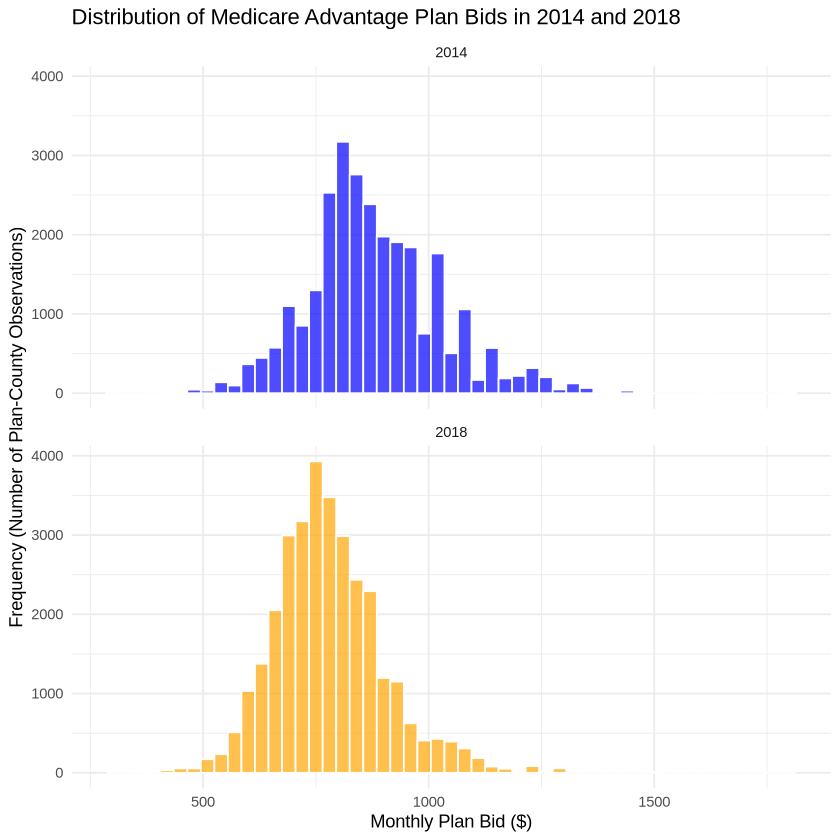

In [34]:
bid_comparison <- ma_summary %>%
  filter(
    year %in% c(2014, 2018),
    snp == "No",                                  
    (as.numeric(planid) < 800 | as.numeric(planid) >= 900),
    !is.na(premium)                                
  ) %>%
  filter(!is.na(bid), bid > 0)

# Create histograms
ggplot(bid_comparison, aes(x = bid, fill = as.factor(year))) +
  geom_histogram(binwidth = 30, alpha = 0.7, color = "white", position = "identity") +
  facet_wrap(~year, ncol = 1) +
  scale_fill_manual(values = c("2014" = "blue", "2018" = "orange")) +
  labs(
    title = "Distribution of Medicare Advantage Plan Bids in 2014 and 2018",
    x = "Monthly Plan Bid ($)",
    y = "Frequency (Number of Plan-County Observations)",
  ) +
  theme_minimal() +
  theme(legend.position = "none")

2018 had a higher number of plan-county observations, showing an overall increase in popularity of Medicare Advantage between the two years. Also, the distribution of bids shifted slightly to the left between 2014 and 2018. While 2014 bids were more widely distributed between $750$ and $1,000$, the 2018 bids were more densely clustered in the $700$ to $850$ range. This suggests that insurers became more aggressive with their pricing as the market changed. 

# Question 3

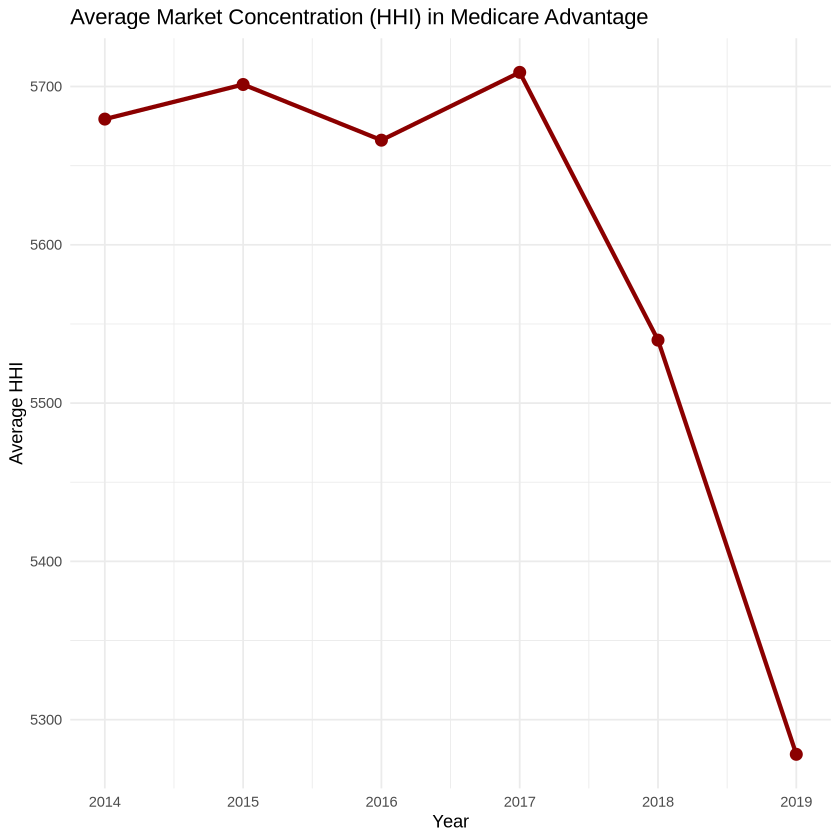

In [45]:
# Prepare Enrollment Data
county_shares <- ma_summary %>%
  group_by(fips, year, parent_org) %>%
  summarize(org_enrollment = sum(avg_enrollment, na.rm = TRUE), .groups = "drop_last") %>%
  mutate(
    total_county_enrollment = sum(org_enrollment, na.rm = TRUE),
    share = (org_enrollment / total_county_enrollment) * 100
  ) %>%
  filter(total_county_enrollment > 0) %>%
  ungroup()

# HHI per county per year
county_hhi <- county_shares %>%
  group_by(fips, year) %>%
  summarize(hhi = sum(share^2), .groups = "drop")

# National avg HHI over time
avg_hhi_trend <- county_hhi %>%
  group_by(year) %>%
  summarize(mean_hhi = mean(hhi, na.rm = TRUE))

# Plot
ggplot(avg_hhi_trend, aes(x = year, y = mean_hhi)) +
  geom_line(color = "darkred", linewidth = 1.2) +
  geom_point(color = "darkred", size = 3) +
  scale_x_continuous(breaks = 2014:2019) +
  labs(
    title = "Average Market Concentration (HHI) in Medicare Advantage",
    x = "Year",
    y = "Average HHI"
  ) +
  theme_minimal()

Average Market Concentration (HHI) in Medicare Advantage remained relatively high but stable from 2014 to 2017 and then declined sharply between 2017-2019. This suggests that while Medicare Advantage markets were still concentrated, they became more competitive as the number of plans increased during this 5 year period.

# Question 4

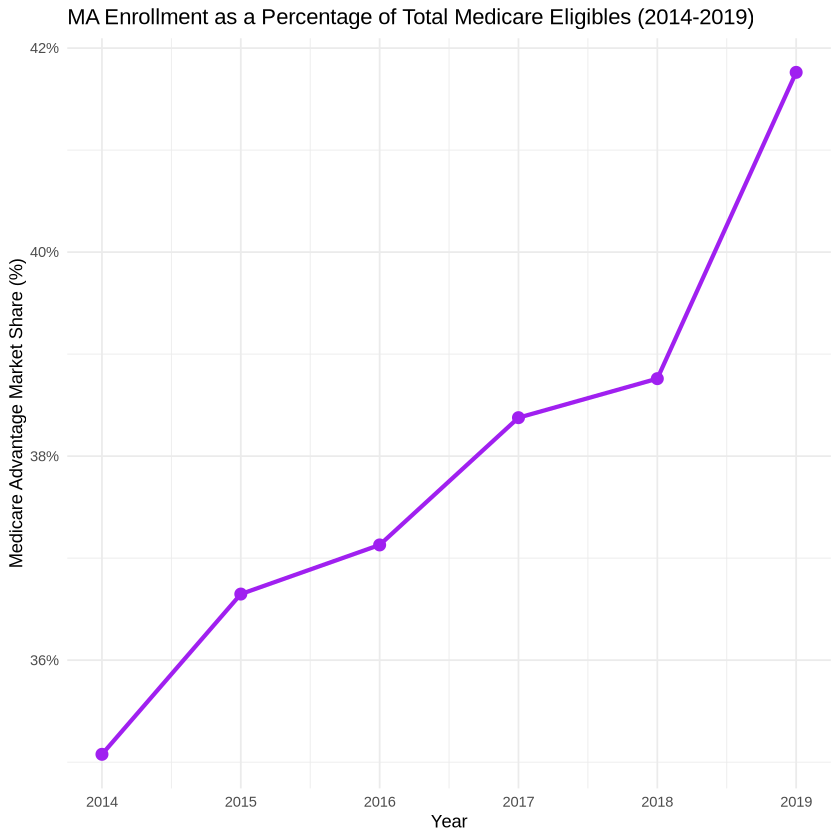

In [46]:
ma_trend <- ma_summary %>%
group_by(year) %>%

# Sum averages across all counties to get national total
summarize(
national_enrolled = sum(avg_enrolled, na.rm = TRUE),
national_eligible = sum(avg_eligibles, na.rm = TRUE)
) %>%

# Calculate %
mutate(ma_share = (national_enrolled / national_eligible) * 100)

# Plot
ggplot(ma_trend, aes(x = year, y = ma_share)) +
  geom_line(color = "purple", linewidth = 1.2) +
  geom_point(color = "purple", size = 3) +
  scale_x_continuous(breaks = 2014:2019) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  labs(
    title = "MA Enrollment as a Percentage of Total Medicare Eligibles (2014-2019)",
    x = "Year",
    y = "Medicare Advantage Market Share (%)",
  ) +
  theme_minimal()

Medicare Advantage has steadily increased in popularity from 2014-2019, with its largest increase in enrollment occuring between 2018-2019. Referring to results from question 2 in addition to these, the combination of more eligibles choosing these plans (market share), more insurers offering them (availability), and increased competition (lower HHI) confirms MA's increase in enrollment during this time.

# Question 5

In [40]:
# Prepare 2018 Data for Qs 5-10
ma_2018 <- ma_summary %>%
  filter(year == 2018) %>%
  group_by(fips) %>%
  mutate(
    total_county_enroll = sum(avg_enrollment, na.rm = TRUE),
    plan_share = if_else(total_county_enroll > 0, avg_enrollment / total_county_enroll, 0),
    county_hhi = sum((plan_share * 100)^2, na.rm = TRUE)
  ) %>%
  ungroup()

# Set thresholds for quantiles
hhi_dist <- ma_2018 %>% distinct(fips, county_hhi)
hhi_thresholds <- quantile(hhi_dist$county_hhi, probs = c(0.33, 0.66), na.rm = TRUE)

ma_2018 <- ma_2018 %>%
  mutate(market_type = case_when(
    county_hhi <= hhi_thresholds[1] ~ "Competitive",
    county_hhi >= hhi_thresholds[2] ~ "Uncompetitive"
  )) %>%
  filter(!is.na(market_type))

q5_results <- ma_2018 %>%
  group_by(market_type) %>%
  summarize(avg_bid = mean(bid, na.rm = TRUE))

q5_table <- q5_results %>%
  mutate(avg_bid = round(avg_bid, 0)) %>%
  rename(
    `Market Type` = market_type,
    `Average Bid ($)` = avg_bid
  ) %>%
  as.data.frame()

print(q5_table)

    Market Type Average Bid ($)
1   Competitive             782
2 Uncompetitive             787


# Question 6

In [41]:
# Prepare data
ma_2018_quartiles <- ma_2018 %>%
filter(!is.na(avg_ffscost)) %>% 
  
# Define quartiles
mutate(ffs_quartile = ntile(avg_ffscost, 4)) %>%

# Create indicator variables
mutate(
    q1_ind = if_else(ffs_quartile == 1, 1, 0),
    q2_ind = if_else(ffs_quartile == 2, 1, 0),
    q3_ind = if_else(ffs_quartile == 3, 1, 0),
    q4_ind = if_else(ffs_quartile == 4, 1, 0)
  )

# Avg bid among treated/control (competitive/uncompetitive) groups for each quartile
q6_summary <- ma_2018_quartiles %>%
group_by(ffs_quartile, market_type) %>%
summarize(avg_bid = mean(bid, na.rm = TRUE), .groups = "drop") %>%
pivot_wider(names_from = market_type, values_from = avg_bid) %>%
rename(Quartile = ffs_quartile)

# Create table
q6_table <- q6_summary %>%
  rename(`FFS Cost Quartile` = Quartile) %>%
  mutate(
    Competitive = paste0("$", format(round(Competitive, 2), nsmall = 2)),
    Uncompetitive = paste0("$", format(round(Uncompetitive, 2), nsmall = 2))
  )

as.data.frame(q6_table)

FFS Cost Quartile,Competitive,Uncompetitive
<int>,<chr>,<chr>
1,$792.57,$810.79
2,$788.77,$785.95
3,$773.82,$772.39
4,$771.03,$784.54


# Question 7

In [42]:
# Prepare data
ma_2018_match <- ma_2018_quartiles %>%
  mutate(tr = if_else(market_type == "Uncompetitive", 1, 0)) %>%
  filter(!is.na(bid))

# 7a. Inverse Variance
m_inv_fit <- suppressWarnings(
m_inv_fit <- matchit(tr ~ ffs_quartile, data = ma_2018_match, 
                     method = "subclass", subclass = 4)
)
m_inv_data <- match.data(m_inv_fit)
model_inv <- lm(bid ~ tr, data = m_inv_data, weights = weights)


# 7b. Mahalanobis
m_maha_fit <- suppressWarnings(
m_maha_fit <- matchit(tr ~ ffs_quartile, data = ma_2018_match, 
                      method = "subclass", subclass = 4)
)
m_maha_data <- match.data(m_maha_fit)
model_maha <- lm(bid ~ tr, data = m_maha_data, weights = weights)


# 7c. Inverse Propensity Weighting
logit_ps <- glm(tr ~ q2_ind + q3_ind + q4_ind, family = binomial, data = ma_2018_match)
ma_2018_match$ps <- predict(logit_ps, type = "response")
ma_2018_match <- ma_2018_match %>%
  mutate(ipw_weight = if_else(tr == 1, 1/ps, 1/(1-ps)))
model_ipw <- lm(bid ~ tr, data = ma_2018_match, weights = ipw_weight)

# 7d. Linear Regression
model_ols <- lm(bid ~ tr * (q2_ind + q3_ind + q4_ind), data = ma_2018_match)
ols_res   <- avg_comparisons(model_ols, variables = "tr")

# Create table with results
q7_table <- data.frame(
  Statistic = c("Estimate", "Std. Error"),
  INV = c(coef(model_inv)["tr"], summary(model_inv)$coefficients["tr", 2]),
  MAH = c(coef(model_maha)["tr"], summary(model_maha)$coefficients["tr", 2]),
  IPW = c(coef(model_ipw)["tr"], summary(model_ipw)$coefficients["tr", 2]),
  OLS = c(ols_res$estimate, ols_res$std.error)
)

print(as.data.frame(q7_table %>% mutate(across(where(is.numeric), ~round(., 3)))), row.names = FALSE)

  Statistic   INV   MAH   IPW   OLS
   Estimate 6.479 6.479 6.919 6.919
 Std. Error 1.957 1.957 1.642 1.959


# Question 8

Results for question 8 across the different estimators are similar but not identical.
The slight difference between the matching group (INV and MAH) and the regression group (IPW and OLS) reflects the difference between 1-to-1 matching (may discard some control units) and full-sample estimators (uses all data). The estimates consistently show that uncompetitive markets lead to higher plan bids compared to competitive, with the effect ranging from a bid price increase of $6.48$ to $6.92$ dollars per month.

# Question 9

In [16]:
# Re-estimate treatment effects using continuous covariates
model_9 <- lm(bid ~ tr * (avg_ffscost + avg_eligibles), data = ma_2018_match)

# Extract ATE
res_9 <- avg_comparisons(model_9, variables = "tr")

# Create table
q9_table <- data.frame(
  Model = c("Quartile Matching (Q7)", "Continuous OLS (Q9)"),
  Estimate = c(ols_res$estimate, res_9$estimate),
  Std_Error = c(ols_res$std.error, res_9$std.error)
)

print(as.data.frame(q9_table %>% mutate(across(where(is.numeric), ~round(., 3)))), row.names = FALSE)

                  Model Estimate Std_Error
 Quartile Matching (Q7)    6.919     1.959
    Continuous OLS (Q9)    5.670     2.700


The estimate decreased from $6.919$ to $5.670$ when moving from quartile-based matching to continuous regression model. The increase in the standard error suggests that there is more variation when taking into account more granular cost data and market scale. Overall, the results confirm that uncompetitive markets lead to higher bids, but the size of this effect is more moderate when we control for continuous FFS costs and total Medicare beneficiaries.

# Question 10

I don't think I've ever worked with this volume of data before, so that in itself was a challenge when it came to running the code and (not so patiently) waiting. Building the data set was where I faced the most issues, as I had to account for different variable names and inconsistent file structures across multiple years of CMS reports. One thing I learned was the importance of standardizing identifiers, like ensuring planid was numeric across all sets, to prevent data loss during joins. What surprised me were the changes that occurred in 2019: seeing the sharp decline in market concentration (HHI) alongside the increases in market share and plan availability made it clear how quickly the competitive landscape can shift in just a year.